<a href="https://colab.research.google.com/github/CMDRZero/DataScienceFundamentalsClass/blob/main/GranBellU2Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Predicting Golf Green Hits via GIR%**
  Featuring S. Scheffler (cuz he's a guy I've seen on tv like once)

### What is Greens in Regulation Percentage (GIR%)?
GIR% is amount of time that the golf ball made it onto the golf green before or at the GIR stroke —the golf green being the small area of short grass around the hole when you begin putting. The GIR stroke is defined as the (par-2)th stroke. A golf stroke being hitting the ball. Par can be considered measure of expected number of strokes for a skilled player.

In practice this means that of the three levels of par: 3, 4, & 5, the GIR's are then 1, 2, & 3. For the easiest, you need to make it to the green on your first stroke, and you have three chances for the hardest.

### So what is S. Scheffler's GIR%?
According to pgatour.com, he has made 935 greens on 1278 holes attempted (71 full courses). This is reported as a mean score of 73.16%.

To begin using python, we need to install the libraries we want to use if they arent already available. I dont strictly need preliz since I utimately use PyMc, but its nice to illustrate the graphs, so I'll install it.

In [ ]:
!pip install preliz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.3/505.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 13.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osqp 0.6.7.post0 requires scipy!=1.12.0,>=0.13.2, but you have scipy 1.12.0 which is incompatible.


In [ ]:
import arviz as az
import pymc as pm     #The engine of prediction
import numpy as np
import preliz as pz   #We are using this so I can make the nice graphs of priors and likelyhoods

Now I need to decide upon a prior model, here we will use a beta function as it is the prior conjugate of the binomial function, and the latter is used to predict the likelyhood of an observed event. What is a prior conjugate? Well, I dont fully know, but when combined with its parent in a prior+likelyhood situation, it makes the math easy. I'm not really worried about math here, but the sample projct used the beta function so I'll use it as well for my prior.

<Axes: >

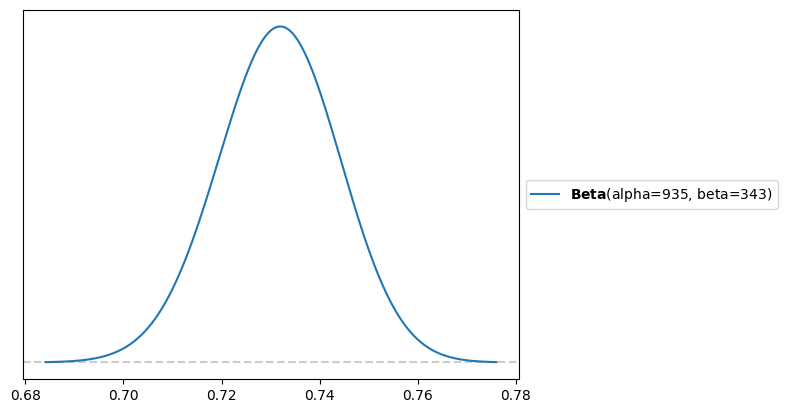

In [ ]:
makes = 935
atmps = 1278
misses = atmps - makes
pz.Beta(alpha=makes,beta=misses).plot_pdf()

Looking at this graph we can see the prior function gives a very high chance that θ, our true GIR%, is around 73%, and that it tapers off very quickly past three percent above or below.

And now to look at the likelyhood of our observed results given some θ. This is the binomial part of the beta binomial

<Axes: >

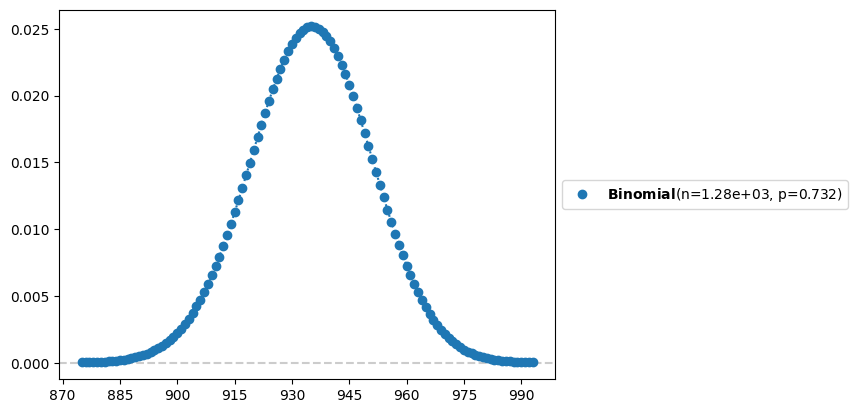

In [ ]:
pz.Binomial(atmps,makes/atmps).plot_pdf()

Now lets make our actual model and build it with PyMC. Here I'm just using the compact notation available because I find its a little bit more elegant without losing understandability. I wish python had a `**` operand because I could do some silly stuff with being like `[1] ** makes ++ [0] ** misses` using custom classes, but alas I cannot.

In [ ]:
#Use numpy to quickly create a sets of 1s and 0s for each make and miss
GIR_data = np.repeat([1,0], repeats = [makes,misses])

Now we use the template given to use, but here I've rewritten the comments into my own language. A with statement in python will handle closing the object if an error occurs which is very important for things like files or here models so that we can handle errors without stranding file handles or partially trained models.

In [ ]:
#Define our model using the python `with` structure
with pm.Model() as model:
  #Define our theta value, or the distribution of true make percentages.
  θ = pm.Beta('θ' , alpha = makes , beta = misses)

  #Define our prediction distribution, which is the binomial of a given theta, weighted by all of the priors.
  y = pm.Bernoulli('y', p = θ, observed = GIR_data)

  #Lets take a large sample of 100 courses to make a graph of what our full distribution looks like
  idata_GIR = pm.sample(100 * 18)

Since we sampled alot of points we can use the plotting function below to see roughly what we'd except our distribution to look like. Due to randomness it might vary a little, but the mean I got was 73% and the HDI-94% ran from 72%-75%, giving a very tight bound.

I suspect the narrowness of the bound being +-2% is due to the sheer amount of attempts fed into the model making anything far the numeric mean very unlikely.

<Axes: title={'center': 'θ'}>

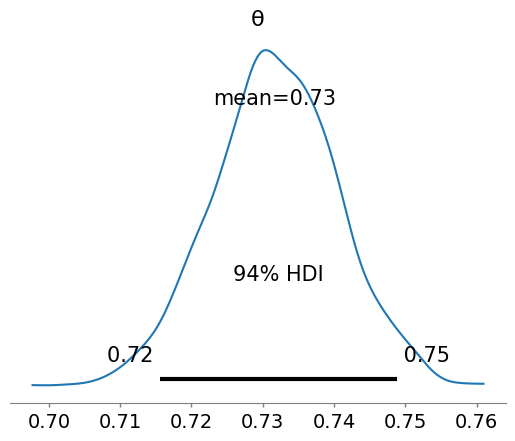

In [ ]:
az.plot_posterior(idata_GIR)

Now we will sample our posterior function to get some guesses, and unlike the notes, I'll save them in a seperate variable because concateninating onto the input feels gross and sloppy to me.

In [ ]:
predictions = pm.sample_posterior_predictive(idata_GIR, model=model)

Inference data with groups:
	> posterior_predictive
	> observed_data

Since we want to predict say the next three games, we'll slice off the first 54 holes and remap them into a set of 3 18 hole courses and return that for our prediction. In this situation the bulk of the formula is just disgarding the anaylsis done on our samples and just getting the raw data.

In [ ]:
courses = 3
games = az.extract(predictions, group="posterior_predictive").sel(sample=0).sel(draw=0) \
  .y.to_series() \          #Get the values from the data prediction
  .values[:courses*18] \    #Go ahead and slice off only what we need and disregard the unneeded data
  .reshape((courses, 18)) \ #Then reshape it into our nonsquare matrix for ease of use
games

array([[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
       [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]])

Just for funsies, I got this as my data from my first run

In [ ]:
ary = np.array([[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
                [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
                [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]])

According to our guess here, Mr. Scheffler is gonne have a bad time all three games on holes 6 and 7.